# MARCHE AVEC GPU

In [3]:
!pip install imageio
from IPython import get_ipython
from IPython.display import display, Video
import imageio

In [4]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import cv2 # Import cv2

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
GAMMA = 0.99
BATCH_SIZE = 64
LR = 1e-3
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 500
TARGET_UPDATE = 10

In [6]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
# Q-Network class
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = deque(maxlen=MEMORY_SIZE)

In [8]:
# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state).argmax(dim=1).item()

# Store transitions in memory
def store_transition(state, action, reward, next_state, done):
    # Ensure state and next_state are in the expected format
    if isinstance(state, np.ndarray) and state.shape != (4,):
      state = np.array(state[:4])
    if isinstance(next_state, np.ndarray) and next_state.shape != (4,):
      next_state = np.array(next_state[:4])
    memory.append((state, action, reward, next_state, done))

In [9]:
# Training function
def train():
    if len(memory) < BATCH_SIZE:
        return

    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # convert states to a compatible format.
    states = np.array(states)
    if len(states.shape) > 2:
      states = np.reshape(states, (BATCH_SIZE, -1))
    states = torch.tensor(states, dtype=torch.float32).to(device)

    # Same for next_states
    next_states = np.array(next_states)
    if len(next_states.shape) > 2:
        next_states = np.reshape(next_states, (BATCH_SIZE, -1))
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

    actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Q-values of the current policy
    q_values = policy_net(states).gather(1, actions).squeeze(1)

    # Double DQN: action selection by policy_net, evaluation by target_net
    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
    next_q_values = target_net(next_states).gather(1, next_actions).squeeze(1)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    # Loss and optimization
    loss = nn.MSELoss()(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [10]:
def generate_video(env_name="CartPole-v1", num_episodes=1, max_steps_per_episode=1000, video_filename='cartpole_trained_model.mp4'):
    frames = []
    env = gym.make(env_name, render_mode="rgb_array")

    for episode in range(num_episodes):
        state, _ = env.reset()
        terminal = False
        current_step = 0
        # Removed preprocessing code that was specific to atari games.

        while not terminal and current_step < max_steps_per_episode:
            frame = env.render()

            if isinstance(frame, list):
              frame = np.array(frame)

            # Corriger la forme de l'image si elle contient une dimension superflue
            if frame is not None and len(frame.shape) == 4 and frame.shape[0] == 1:
                frame = np.squeeze(frame, axis=0)  # Supprime la première dimension

            # Vérification de la forme correcte (400, 600, 3)
            if frame is not None and frame.shape == (400, 600, 3):
                frames.append(frame)
            else:
                print(f"Image ignorée à l'étape {current_step} : format inattendu {frame.shape if frame is not None else 'None'}")

            # Prendre une action selon le modèle entraîné
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action = policy_net(state_tensor).argmax(dim=1).item()

            next_state, reward, terminal, _, _ = env.step(action)
            # no longer needs to preprocess next_state since it is no longer an atari game.
            state = next_state
            current_step += 1

    env.close()

    # Enregistrer les frames en une vidéo
    if frames:
        imageio.mimsave(video_filename, frames, fps=30)
        display(Video(video_filename, embed=True))
    else:
        print("No frames captured.")

In [11]:
# Main training loop
epsilon = EPSILON_START
rewards_per_episode_1 = []
for episode in range(200):
    state, _ = env.reset() # reset the env to get the observations in the correct format.
    total_reward = 0

    # Ensure state is in the correct format
    if isinstance(state, np.ndarray) and state.shape != (4,):
      state = np.array(state[:4])

    for t in range(1000):
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        # ensure next_state is in the correct format.
        if isinstance(next_state, np.ndarray) and next_state.shape != (4,):
          next_state = np.array(next_state[:4])

        store_transition(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train()

        if done:
            break

    # Epsilon decay
    epsilon = max(EPSILON_END, EPSILON_START - episode / EPSILON_DECAY)
    rewards_per_episode_1.append(total_reward)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if episode % 100 == 0:
      generate_video()

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

ValueError: too many values to unpack (expected 2)

In [12]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import imageio
from IPython.display import Video, display

In [13]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
GAMMA = 0.99
BATCH_SIZE = 64
LR = 1e-3
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 500
TARGET_UPDATE = 10
ALPHA = 0.6  # Prioritization exponent
BETA_START = 0.4
BETA_INCREMENT = 0.001

In [14]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [15]:
# Prioritized Experience Replay class
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def add(self, state, action, reward, next_state, done, error):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta):
        if len(self.buffer) == 0:
            return [], [], [], [], [], []

        priorities = self.priorities[: len(self.buffer)]
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

        states, actions, rewards, next_states, dones = zip(*samples)
        return (indices, torch.tensor(np.array(states), dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device),
                torch.tensor(rewards, dtype=torch.float32).to(device),
                torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.float32).to(device), weights)

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors.detach().cpu().numpy()):
            self.priorities[idx] = error + 1e-5

In [16]:
# Q-Network class
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = PrioritizedReplayBuffer(MEMORY_SIZE, ALPHA)

In [17]:
# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state).argmax(dim=1).item()

# Store transitions in memory
def store_transition(state, action, reward, next_state, done):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_val = policy_net(state_tensor)[0, action].item()
        next_q_val = target_net(next_state_tensor).max(1)[0].item()
        target = reward + (GAMMA * next_q_val * (1 - done))
        error = abs(q_val - target)
    memory.add(state, action, reward, next_state, done, error)

In [18]:
# Training function
def train(beta):
    if len(memory.buffer) < BATCH_SIZE:
        return

    indices, states, actions, rewards, next_states, dones, weights = memory.sample(BATCH_SIZE, beta)

    # Q-values of the current policy
    q_values = policy_net(states).gather(1, actions).squeeze(1)

    # Double DQN: action selection by policy_net, evaluation by target_net
    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
    next_q_values = target_net(next_states).gather(1, next_actions).squeeze(1)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    # Loss and optimization
    errors = torch.abs(q_values - target_q_values).detach()
    memory.update_priorities(indices, errors)

    loss = (weights * (q_values - target_q_values.detach()).pow(2)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [20]:
# Main training loop
epsilon = EPSILON_START
beta = BETA_START
rewards_per_episode_2 = []
for episode in range(200):
    state = env.reset()[0]
    total_reward = 0

    for t in range(1000):
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        store_transition(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train(beta)

        if done:
            break

    # Epsilon and beta decay
    epsilon = max(EPSILON_END, EPSILON_START - episode / EPSILON_DECAY)
    beta = min(1.0, beta + BETA_INCREMENT)
    rewards_per_episode_2.append(total_reward)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if episode % 100 == 0:
        generate_video()

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}, Beta: {beta:.2f}")

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


ValueError: not enough values to unpack (expected 5, got 4)

# MARCHE SUR CPU

In [41]:
!pip install imageio
from IPython import get_ipython
from IPython.display import display, Video
import imageio
from IPython.display import display, Video
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import cv2 # Import cv2

In [42]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
GAMMA = 0.99
BATCH_SIZE = 64
LR = 1e-3
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
NUM_EPISODES = 500
EPSILON_DECAY = NUM_EPISODES
TARGET_UPDATE = 10

In [43]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Q-Network class
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = deque(maxlen=MEMORY_SIZE)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [44]:
# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state).argmax(dim=1).item()

# Store transitions in memory
def store_transition(state, action, reward, next_state, done):
    # Ensure state and next_state are in the expected format
    if isinstance(state, np.ndarray) and state.shape != (4,):
      state = np.array(state[:4])
    if isinstance(next_state, np.ndarray) and next_state.shape != (4,):
      next_state = np.array(next_state[:4])
    memory.append((state, action, reward, next_state, done))

In [45]:
# Training function
def train():
    if len(memory) < BATCH_SIZE:
        return

    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # convert states to a compatible format.
    states = np.array(states)
    if len(states.shape) > 2:
      states = np.reshape(states, (BATCH_SIZE, -1))
    states = torch.tensor(states, dtype=torch.float32).to(device)

    # Same for next_states
    next_states = np.array(next_states)
    if len(next_states.shape) > 2:
        next_states = np.reshape(next_states, (BATCH_SIZE, -1))
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

    actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Q-values of the current policy
    q_values = policy_net(states).gather(1, actions).squeeze(1)

    # Double DQN: action selection by policy_net, evaluation by target_net
    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
    next_q_values = target_net(next_states).gather(1, next_actions).squeeze(1)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    # Loss and optimization
    loss = nn.MSELoss()(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [46]:
def generate_video(network, env_name="CartPole-v1", num_episodes=1, max_steps_per_episode=2000, video_filename='cartpole_trained_model.mp4'):
    frames = []
    env = gym.make(env_name, render_mode="rgb_array")

    for episode in range(num_episodes):
        state = env.reset()
        terminal = False
        current_step = 0
        # Removed preprocessing code that was specific to atari games.

        while not terminal and current_step < max_steps_per_episode:
            frame = env.render()

            if isinstance(frame, list):
              frame = np.array(frame)

            # Corriger la forme de l'image si elle contient une dimension superflue
            if frame is not None and len(frame.shape) == 4 and frame.shape[0] == 1:
                frame = np.squeeze(frame, axis=0)  # Supprime la première dimension

            # Vérification de la forme correcte (400, 600, 3)
            if frame is not None and frame.shape == (400, 600, 3):
                frames.append(frame)
            else:
                print(f"Image ignorée à l'étape {current_step} : format inattendu {frame.shape if frame is not None else 'None'}")

            # Prendre une action selon le modèle entraîné
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action = network(state_tensor).argmax(dim=1).item()

            next_state, reward, terminal, _ = env.step(action)
            # no longer needs to preprocess next_state since it is no longer an atari game.
            state = next_state
            current_step += 1

    env.close()

    # Enregistrer les frames en une vidéo
    if frames:
        imageio.mimsave(video_filename, frames, fps=30)
        display(Video(video_filename, embed=True))
    else:
        print("No frames captured.")

In [47]:
# Main training loop
epsilon = EPSILON_START
rewards_per_episode_1 = []
for episode in range(NUM_EPISODES):
    state = env.reset() # reset the env to get the observations in the correct format.
    total_reward = 0

    # Ensure state is in the correct format
    if isinstance(state, np.ndarray) and state.shape != (4,):
      state = np.array(state[:4])

    for t in range(1000):
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        # ensure next_state is in the correct format.
        if isinstance(next_state, np.ndarray) and next_state.shape != (4,):
          next_state = np.array(next_state[:4])

        store_transition(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train()

        if done:
            break

    # Epsilon decay
    epsilon = max(EPSILON_END, EPSILON_START - episode / EPSILON_DECAY)
    rewards_per_episode_1.append(total_reward)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if episode % 100 == 0:
      generate_video(policy_net)

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 19.0, Epsilon: 1.00
Episode 1, Total Reward: 20.0, Epsilon: 1.00
Episode 2, Total Reward: 34.0, Epsilon: 1.00
Episode 3, Total Reward: 53.0, Epsilon: 0.99
Episode 4, Total Reward: 36.0, Epsilon: 0.99
Episode 5, Total Reward: 38.0, Epsilon: 0.99
Episode 6, Total Reward: 20.0, Epsilon: 0.99
Episode 7, Total Reward: 23.0, Epsilon: 0.99
Episode 8, Total Reward: 27.0, Epsilon: 0.98
Episode 9, Total Reward: 28.0, Epsilon: 0.98
Episode 10, Total Reward: 16.0, Epsilon: 0.98
Episode 11, Total Reward: 55.0, Epsilon: 0.98
Episode 12, Total Reward: 13.0, Epsilon: 0.98
Episode 13, Total Reward: 41.0, Epsilon: 0.97
Episode 14, Total Reward: 26.0, Epsilon: 0.97
Episode 15, Total Reward: 19.0, Epsilon: 0.97
Episode 16, Total Reward: 28.0, Epsilon: 0.97
Episode 17, Total Reward: 36.0, Epsilon: 0.97
Episode 18, Total Reward: 25.0, Epsilon: 0.96
Episode 19, Total Reward: 104.0, Epsilon: 0.96
Episode 20, Total Reward: 46.0, Epsilon: 0.96
Episode 21, Total Reward: 10.0, Epsilon: 0.

Episode 100, Total Reward: 78.0, Epsilon: 0.80
Episode 101, Total Reward: 19.0, Epsilon: 0.80
Episode 102, Total Reward: 46.0, Epsilon: 0.80
Episode 103, Total Reward: 15.0, Epsilon: 0.79
Episode 104, Total Reward: 43.0, Epsilon: 0.79
Episode 105, Total Reward: 50.0, Epsilon: 0.79
Episode 106, Total Reward: 102.0, Epsilon: 0.79
Episode 107, Total Reward: 86.0, Epsilon: 0.79
Episode 108, Total Reward: 15.0, Epsilon: 0.78
Episode 109, Total Reward: 25.0, Epsilon: 0.78
Episode 110, Total Reward: 29.0, Epsilon: 0.78
Episode 111, Total Reward: 24.0, Epsilon: 0.78
Episode 112, Total Reward: 52.0, Epsilon: 0.78
Episode 113, Total Reward: 34.0, Epsilon: 0.77
Episode 114, Total Reward: 50.0, Epsilon: 0.77
Episode 115, Total Reward: 28.0, Epsilon: 0.77
Episode 116, Total Reward: 56.0, Epsilon: 0.77
Episode 117, Total Reward: 37.0, Epsilon: 0.77
Episode 118, Total Reward: 15.0, Epsilon: 0.76
Episode 119, Total Reward: 31.0, Epsilon: 0.76
Episode 120, Total Reward: 180.0, Epsilon: 0.76
Episode 121

Episode 200, Total Reward: 111.0, Epsilon: 0.60
Episode 201, Total Reward: 18.0, Epsilon: 0.60
Episode 202, Total Reward: 22.0, Epsilon: 0.60
Episode 203, Total Reward: 19.0, Epsilon: 0.59
Episode 204, Total Reward: 28.0, Epsilon: 0.59
Episode 205, Total Reward: 95.0, Epsilon: 0.59
Episode 206, Total Reward: 47.0, Epsilon: 0.59
Episode 207, Total Reward: 18.0, Epsilon: 0.59
Episode 208, Total Reward: 71.0, Epsilon: 0.58
Episode 209, Total Reward: 13.0, Epsilon: 0.58
Episode 210, Total Reward: 39.0, Epsilon: 0.58
Episode 211, Total Reward: 28.0, Epsilon: 0.58
Episode 212, Total Reward: 36.0, Epsilon: 0.58
Episode 213, Total Reward: 77.0, Epsilon: 0.57
Episode 214, Total Reward: 70.0, Epsilon: 0.57
Episode 215, Total Reward: 17.0, Epsilon: 0.57
Episode 216, Total Reward: 107.0, Epsilon: 0.57
Episode 217, Total Reward: 45.0, Epsilon: 0.57
Episode 218, Total Reward: 89.0, Epsilon: 0.56
Episode 219, Total Reward: 153.0, Epsilon: 0.56
Episode 220, Total Reward: 23.0, Epsilon: 0.56
Episode 22

Episode 300, Total Reward: 115.0, Epsilon: 0.40
Episode 301, Total Reward: 46.0, Epsilon: 0.40
Episode 302, Total Reward: 76.0, Epsilon: 0.40
Episode 303, Total Reward: 127.0, Epsilon: 0.39
Episode 304, Total Reward: 46.0, Epsilon: 0.39
Episode 305, Total Reward: 22.0, Epsilon: 0.39
Episode 306, Total Reward: 140.0, Epsilon: 0.39
Episode 307, Total Reward: 245.0, Epsilon: 0.39
Episode 308, Total Reward: 231.0, Epsilon: 0.38
Episode 309, Total Reward: 41.0, Epsilon: 0.38
Episode 310, Total Reward: 110.0, Epsilon: 0.38
Episode 311, Total Reward: 29.0, Epsilon: 0.38
Episode 312, Total Reward: 15.0, Epsilon: 0.38
Episode 313, Total Reward: 127.0, Epsilon: 0.37
Episode 314, Total Reward: 26.0, Epsilon: 0.37
Episode 315, Total Reward: 119.0, Epsilon: 0.37
Episode 316, Total Reward: 17.0, Epsilon: 0.37
Episode 317, Total Reward: 102.0, Epsilon: 0.37
Episode 318, Total Reward: 23.0, Epsilon: 0.36
Episode 319, Total Reward: 94.0, Epsilon: 0.36
Episode 320, Total Reward: 124.0, Epsilon: 0.36
Epi

Episode 400, Total Reward: 42.0, Epsilon: 0.20
Episode 401, Total Reward: 136.0, Epsilon: 0.20
Episode 402, Total Reward: 123.0, Epsilon: 0.20
Episode 403, Total Reward: 158.0, Epsilon: 0.19
Episode 404, Total Reward: 124.0, Epsilon: 0.19
Episode 405, Total Reward: 13.0, Epsilon: 0.19
Episode 406, Total Reward: 123.0, Epsilon: 0.19
Episode 407, Total Reward: 13.0, Epsilon: 0.19
Episode 408, Total Reward: 13.0, Epsilon: 0.18
Episode 409, Total Reward: 16.0, Epsilon: 0.18
Episode 410, Total Reward: 132.0, Epsilon: 0.18
Episode 411, Total Reward: 272.0, Epsilon: 0.18
Episode 412, Total Reward: 169.0, Epsilon: 0.18
Episode 413, Total Reward: 15.0, Epsilon: 0.17
Episode 414, Total Reward: 152.0, Epsilon: 0.17
Episode 415, Total Reward: 71.0, Epsilon: 0.17
Episode 416, Total Reward: 156.0, Epsilon: 0.17
Episode 417, Total Reward: 116.0, Epsilon: 0.17
Episode 418, Total Reward: 129.0, Epsilon: 0.16
Episode 419, Total Reward: 123.0, Epsilon: 0.16
Episode 420, Total Reward: 97.0, Epsilon: 0.16


In [49]:
generate_video(policy_net)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [50]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import imageio
from IPython.display import Video, display

In [51]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
GAMMA = 0.99
BATCH_SIZE = 64
LR = 1e-3
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
NUM_EPISODES = 500
EPSILON_DECAY = NUM_EPISODES
TARGET_UPDATE = 10
ALPHA = 0.6  # Prioritization exponent
BETA_START = 0.4
BETA_INCREMENT = 0.001

In [52]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [53]:
# Prioritized Experience Replay class
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def add(self, state, action, reward, next_state, done, error):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta):
        if len(self.buffer) == 0:
            return [], [], [], [], [], []

        priorities = self.priorities[: len(self.buffer)]
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

        states, actions, rewards, next_states, dones = zip(*samples)
        return (indices, torch.tensor(np.array(states), dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device),
                torch.tensor(rewards, dtype=torch.float32).to(device),
                torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.float32).to(device), weights)

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors.detach().cpu().numpy()):
            self.priorities[idx] = error + 1e-5

In [54]:
# Q-Network class
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = PrioritizedReplayBuffer(MEMORY_SIZE, ALPHA)

In [55]:
# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state).argmax(dim=1).item()

# Store transitions in memory
def store_transition(state, action, reward, next_state, done):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_val = policy_net(state_tensor)[0, action].item()
        next_q_val = target_net(next_state_tensor).max(1)[0].item()
        target = reward + (GAMMA * next_q_val * (1 - done))
        error = abs(q_val - target)
    memory.add(state, action, reward, next_state, done, error)

In [56]:
# Training function
def train(beta):
    if len(memory.buffer) < BATCH_SIZE:
        return

    indices, states, actions, rewards, next_states, dones, weights = memory.sample(BATCH_SIZE, beta)

    # Q-values of the current policy
    q_values = policy_net(states).gather(1, actions).squeeze(1)

    # Double DQN: action selection by policy_net, evaluation by target_net
    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
    next_q_values = target_net(next_states).gather(1, next_actions).squeeze(1)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    # Loss and optimization
    errors = torch.abs(q_values - target_q_values).detach()
    memory.update_priorities(indices, errors)

    loss = (weights * (q_values - target_q_values.detach()).pow(2)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [57]:
# Main training loop
epsilon = EPSILON_START
beta = BETA_START
rewards_per_episode_2 = []
for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0

    for t in range(1000):
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        store_transition(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train(beta)

        if done:
            break

    # Epsilon and beta decay
    epsilon = max(EPSILON_END, EPSILON_START - episode / EPSILON_DECAY)
    beta = min(1.0, beta + BETA_INCREMENT)
    rewards_per_episode_2.append(total_reward)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if episode % 100 == 0:
        generate_video(policy_net)

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}, Beta: {beta:.2f}")

Episode 0, Total Reward: 31.0, Epsilon: 1.00, Beta: 0.40
Episode 1, Total Reward: 24.0, Epsilon: 1.00, Beta: 0.40
Episode 2, Total Reward: 11.0, Epsilon: 1.00, Beta: 0.40
Episode 3, Total Reward: 22.0, Epsilon: 0.99, Beta: 0.40
Episode 4, Total Reward: 11.0, Epsilon: 0.99, Beta: 0.41
Episode 5, Total Reward: 21.0, Epsilon: 0.99, Beta: 0.41
Episode 6, Total Reward: 12.0, Epsilon: 0.99, Beta: 0.41
Episode 7, Total Reward: 21.0, Epsilon: 0.99, Beta: 0.41
Episode 8, Total Reward: 12.0, Epsilon: 0.98, Beta: 0.41
Episode 9, Total Reward: 33.0, Epsilon: 0.98, Beta: 0.41
Episode 10, Total Reward: 17.0, Epsilon: 0.98, Beta: 0.41
Episode 11, Total Reward: 23.0, Epsilon: 0.98, Beta: 0.41
Episode 12, Total Reward: 17.0, Epsilon: 0.98, Beta: 0.41
Episode 13, Total Reward: 45.0, Epsilon: 0.97, Beta: 0.41
Episode 14, Total Reward: 20.0, Epsilon: 0.97, Beta: 0.42
Episode 15, Total Reward: 32.0, Epsilon: 0.97, Beta: 0.42
Episode 16, Total Reward: 11.0, Epsilon: 0.97, Beta: 0.42
Episode 17, Total Reward

Episode 100, Total Reward: 22.0, Epsilon: 0.80, Beta: 0.50
Episode 101, Total Reward: 15.0, Epsilon: 0.80, Beta: 0.50
Episode 102, Total Reward: 40.0, Epsilon: 0.80, Beta: 0.50
Episode 103, Total Reward: 34.0, Epsilon: 0.79, Beta: 0.50
Episode 104, Total Reward: 16.0, Epsilon: 0.79, Beta: 0.51
Episode 105, Total Reward: 31.0, Epsilon: 0.79, Beta: 0.51
Episode 106, Total Reward: 37.0, Epsilon: 0.79, Beta: 0.51
Episode 107, Total Reward: 34.0, Epsilon: 0.79, Beta: 0.51
Episode 108, Total Reward: 19.0, Epsilon: 0.78, Beta: 0.51
Episode 109, Total Reward: 96.0, Epsilon: 0.78, Beta: 0.51
Episode 110, Total Reward: 34.0, Epsilon: 0.78, Beta: 0.51
Episode 111, Total Reward: 47.0, Epsilon: 0.78, Beta: 0.51
Episode 112, Total Reward: 18.0, Epsilon: 0.78, Beta: 0.51
Episode 113, Total Reward: 41.0, Epsilon: 0.77, Beta: 0.51
Episode 114, Total Reward: 13.0, Epsilon: 0.77, Beta: 0.52
Episode 115, Total Reward: 18.0, Epsilon: 0.77, Beta: 0.52
Episode 116, Total Reward: 33.0, Epsilon: 0.77, Beta: 0.

Episode 200, Total Reward: 74.0, Epsilon: 0.60, Beta: 0.60
Episode 201, Total Reward: 32.0, Epsilon: 0.60, Beta: 0.60
Episode 202, Total Reward: 83.0, Epsilon: 0.60, Beta: 0.60
Episode 203, Total Reward: 37.0, Epsilon: 0.59, Beta: 0.60
Episode 204, Total Reward: 56.0, Epsilon: 0.59, Beta: 0.61
Episode 205, Total Reward: 131.0, Epsilon: 0.59, Beta: 0.61
Episode 206, Total Reward: 51.0, Epsilon: 0.59, Beta: 0.61
Episode 207, Total Reward: 57.0, Epsilon: 0.59, Beta: 0.61
Episode 208, Total Reward: 61.0, Epsilon: 0.58, Beta: 0.61
Episode 209, Total Reward: 66.0, Epsilon: 0.58, Beta: 0.61
Episode 210, Total Reward: 22.0, Epsilon: 0.58, Beta: 0.61
Episode 211, Total Reward: 18.0, Epsilon: 0.58, Beta: 0.61
Episode 212, Total Reward: 21.0, Epsilon: 0.58, Beta: 0.61
Episode 213, Total Reward: 27.0, Epsilon: 0.57, Beta: 0.61
Episode 214, Total Reward: 82.0, Epsilon: 0.57, Beta: 0.62
Episode 215, Total Reward: 48.0, Epsilon: 0.57, Beta: 0.62
Episode 216, Total Reward: 20.0, Epsilon: 0.57, Beta: 0

Episode 300, Total Reward: 30.0, Epsilon: 0.40, Beta: 0.70
Episode 301, Total Reward: 84.0, Epsilon: 0.40, Beta: 0.70
Episode 302, Total Reward: 71.0, Epsilon: 0.40, Beta: 0.70
Episode 303, Total Reward: 26.0, Epsilon: 0.39, Beta: 0.70
Episode 304, Total Reward: 92.0, Epsilon: 0.39, Beta: 0.71
Episode 305, Total Reward: 175.0, Epsilon: 0.39, Beta: 0.71
Episode 306, Total Reward: 75.0, Epsilon: 0.39, Beta: 0.71
Episode 307, Total Reward: 394.0, Epsilon: 0.39, Beta: 0.71
Episode 308, Total Reward: 431.0, Epsilon: 0.38, Beta: 0.71
Episode 309, Total Reward: 39.0, Epsilon: 0.38, Beta: 0.71
Episode 310, Total Reward: 134.0, Epsilon: 0.38, Beta: 0.71
Episode 311, Total Reward: 67.0, Epsilon: 0.38, Beta: 0.71
Episode 312, Total Reward: 212.0, Epsilon: 0.38, Beta: 0.71
Episode 313, Total Reward: 168.0, Epsilon: 0.37, Beta: 0.71
Episode 314, Total Reward: 71.0, Epsilon: 0.37, Beta: 0.72
Episode 315, Total Reward: 136.0, Epsilon: 0.37, Beta: 0.72
Episode 316, Total Reward: 39.0, Epsilon: 0.37, B

Episode 400, Total Reward: 104.0, Epsilon: 0.20, Beta: 0.80
Episode 401, Total Reward: 33.0, Epsilon: 0.20, Beta: 0.80
Episode 402, Total Reward: 15.0, Epsilon: 0.20, Beta: 0.80
Episode 403, Total Reward: 29.0, Epsilon: 0.19, Beta: 0.80
Episode 404, Total Reward: 20.0, Epsilon: 0.19, Beta: 0.81
Episode 405, Total Reward: 88.0, Epsilon: 0.19, Beta: 0.81
Episode 406, Total Reward: 20.0, Epsilon: 0.19, Beta: 0.81
Episode 407, Total Reward: 116.0, Epsilon: 0.19, Beta: 0.81
Episode 408, Total Reward: 271.0, Epsilon: 0.18, Beta: 0.81
Episode 409, Total Reward: 96.0, Epsilon: 0.18, Beta: 0.81
Episode 410, Total Reward: 45.0, Epsilon: 0.18, Beta: 0.81
Episode 411, Total Reward: 111.0, Epsilon: 0.18, Beta: 0.81
Episode 412, Total Reward: 17.0, Epsilon: 0.18, Beta: 0.81
Episode 413, Total Reward: 18.0, Epsilon: 0.17, Beta: 0.81
Episode 414, Total Reward: 141.0, Epsilon: 0.17, Beta: 0.82
Episode 415, Total Reward: 296.0, Epsilon: 0.17, Beta: 0.82
Episode 416, Total Reward: 14.0, Epsilon: 0.17, Be

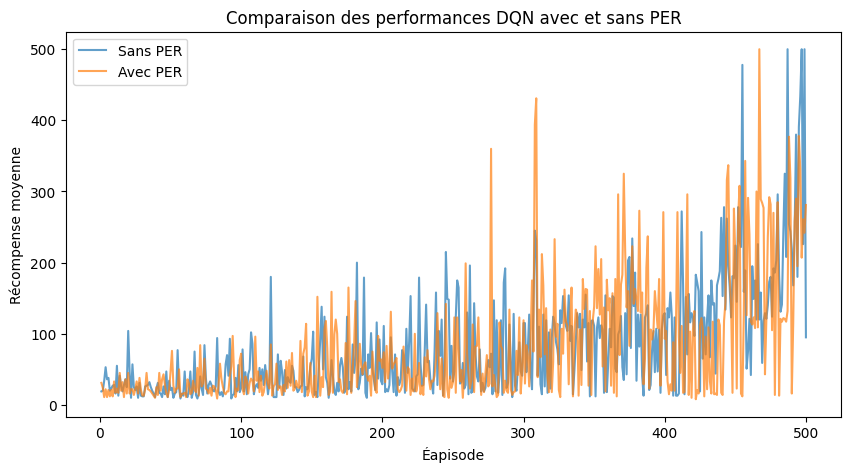

In [58]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
X = np.linspace(1, len(rewards_per_episode_1), len(rewards_per_episode_1))
plt.plot(X, rewards_per_episode_1, label="Sans PER", alpha=0.7)
plt.plot(X, rewards_per_episode_2, label="Avec PER", alpha=0.7)
plt.xlabel("Éapisode")
plt.ylabel("Récompense moyenne")
plt.title("Comparaison des performances DQN avec et sans PER")
plt.legend()
plt.show()

In [ ]:
!pip install ale-py
!pip install gym[atari]
!pip install gym[accept-rom-license]

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2

# Set device based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network for the Q-learning model
class QNetwork(nn.Module):
    def __init__(self, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Preprocess the observation
def preprocess(obs):
    if obs is None or obs.size == 0:
        raise ValueError("Observation is empty or None")

    if len(obs.shape) == 3:
        obs = np.mean(obs, axis=2).astype(np.uint8)

    obs = obs[34:194, :]  # Crop the playing area

    if obs.size == 0:
        raise ValueError("Cropped observation is empty")

    obs = cv2.resize(obs, (84, 84))
    obs = obs / 255.0

    # Supprimer l'ajout du canal supplémentaire
    return obs


# Hyperparameters
BUFFER_SIZE = 100000
BATCH_SIZE = 32
GAMMA = 0.99
LR = 0.0001
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 50000
TARGET_UPDATE = 1000
NUM_EPISODES = 5000

# Setup environment
env = gym.make("ALE/Breakout-v5")
action_size = env.action_space.n

# Create two Q-networks
q_network_1 = QNetwork(action_size).to(device)
q_network_2 = QNetwork(action_size).to(device)
target_network_1 = QNetwork(action_size).to(device)
target_network_2 = QNetwork(action_size).to(device)

# Copy weights to target networks
target_network_1.load_state_dict(q_network_1.state_dict())
target_network_2.load_state_dict(q_network_2.state_dict())

optimizer_1 = optim.Adam(q_network_1.parameters(), lr=LR)
optimizer_2 = optim.Adam(q_network_2.parameters(), lr=LR)

memory = deque(maxlen=BUFFER_SIZE)

# Exploration decay
def get_epsilon(step):
    return EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-1.0 * step / EPSILON_DECAY)

# Store experience
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state), np.array(action), np.array(reward),
                np.array(next_state), np.array(done))

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(BUFFER_SIZE)

# Train the model
def train():
    if len(replay_buffer) < BATCH_SIZE:
        return

    state, action, reward, next_state, done = replay_buffer.sample(BATCH_SIZE)

    state = torch.tensor(state, dtype=torch.float32).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
    action = torch.tensor(action, dtype=torch.long).to(device)
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    done = torch.tensor(done, dtype=torch.float32).to(device)

    # Double Q-Learning update
    with torch.no_grad():
        q1_next = q_network_1(next_state).float()
        q2_next = q_network_2(next_state).float()
        best_actions = torch.argmax(q1_next, dim=1)
        q1_target = target_network_1(next_state)
        q2_target = target_network_2(next_state)
        next_q_values = reward + GAMMA * q2_target.gather(1, best_actions.unsqueeze(1)).squeeze(1) * (1 - done)

    # Q1 update
    q1_values = q_network_1(state).gather(1, action.unsqueeze(1)).squeeze(1)
    loss_1 = nn.MSELoss()(q1_values, next_q_values)
    optimizer_1.zero_grad()
    loss_1.backward()
    optimizer_1.step()

    # Q2 update
    with torch.no_grad():
        best_actions_2 = torch.argmax(q2_next, dim=1)
        next_q_values_2 = reward + GAMMA * q1_target.gather(1, best_actions_2.unsqueeze(1)).squeeze(1) * (1 - done)

    q2_values = q_network_2(state).gather(1, action.unsqueeze(1)).squeeze(1)
    loss_2 = nn.MSELoss()(q2_values, next_q_values_2)
    optimizer_2.zero_grad()
    loss_2.backward()
    optimizer_2.step()

def generate_video(env_name="ALE/Breakout-v5", num_episodes=1, max_steps_per_episode=1000, video_filename='pong_env_video.mp4'):
    frames = []
    env = gym.make(env_name, render_mode="rgb_array")

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = preprocess(state)
        state = np.stack([state] * 4, axis=0)
        terminal = False
        current_step = 0

        while not terminal and current_step < max_steps_per_episode:
            frame = env.render()
            if frame is not None and len(frame.shape) == 3:
                frames.append(frame)

            # Choose action
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q1_values = q_network_1(state_tensor)
            action = torch.argmax(q1_values).item()

            next_state, reward, terminal, _, _ = env.step(action)
            next_state = preprocess(next_state)
            state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

            current_step += 1

    env.close()

    if frames:
        imageio.mimsave(video_filename, frames, fps=30)
        display(Video(video_filename, embed=True))
    else:
        print("No frames captured.")


# Main training loop
for episode in range(NUM_EPISODES):
    print(f'episode: {episode}')
    state, _ = env.reset()
    state = preprocess(state)
    state = np.stack([state] * 4, axis=0)

    total_reward = 0
    done = False
    step = 0
    max_steps_per_episode = 500

    while not done and step < max_steps_per_episode:
        epsilon = get_epsilon(step)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q1_values = q_network_1(state_tensor)
            action = torch.argmax(q1_values).item()

        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess(next_state)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train()

        if step % TARGET_UPDATE == 0:
            target_network_1.load_state_dict(q_network_1.state_dict())
            target_network_2.load_state_dict(q_network_2.state_dict())

        step += 1

    print(f"Episode {episode+1}: Total Reward: {total_reward}")
    if (episode + 1) % 100 == 0:
        generate_video()

env.close()
